# Twin-Delayed Deep Deterministic Policy Gradients

Authors: Eshan Savla, Raphael Aberle, Leo Schäfer

<br>
This Jupyter Notebook gives an overview to the Twin-Delayed Deep Deterministic Policy Gradients (TD3).


**Table of contents**:

   - DDPG - brief summary   ---> ?

1. Differences TD3 to DDPG <br>
   1.1. Motivation of TD3 <br>
   1.1. Implementation steps <br>
      1.1.1. Clipped double Q-Learning <br>
      1.1.2. Delayed policy update <br>
      1.1.3. Target policy smooting
2. Our TD3 implementation <br>
   2.1. RL extension <br>
   2.2. Hyperparameters <br>
   2.3. Training <br>
   2.3. Enjoy 
3. Test environment - Ant-v3
4. Usage of RL TD3 algorithm <br>
   4.1. Training<br>
   4.2. Enjoy
5. Benchmark - Discussion <br>
   5.1. Our TD3 vs. DDPG <br>
      5.1.1. Learning phase <br>
      5.1.2. Trained model <br>
   5.2. TD3 trained model - Hyperparameter tests <br>
   5.3. Our TD3 Best vs. Stable Baselines
6. Summary 
7. Conclusion 
8. Further material

<br> 
<p>

**Info**: 
- Add mathematical equations from spinning up in the markdown and then the implementation (reference to code lines)

- - - 

## **1. Differences DDPG and TD3**

TD3 is a direct successor of DDPG and improves it using three major extensions.

### 1.1. Motivation of TD3

**==> Insert graphic Overview for TD3**


Deep Deterministic Policy Gradient (DPPG) deaks with several issues, such as: 
- Overestimation Bias: DDPG tends to overestimate the Q-Values with it's one critic network 
- policy exploits the errors in the Q-function
--> policy breaking

- High senitivity to hyperparameter: DDPG reacts strongly to changes in hyperparameters
- Exploration is limited: Exploration is inherent difficult for the DDPG Agent
- Limited robustness while learning: The learning is relatively unstable. Larger samples sizes are needed for stability.
  
- Q-function overestimates Q-values dramatically

### 1.1 Implementation Steps

The below shown Pseudocode gives an overview to the fundamental changes of TD3 compared to DDPG. <br>
These individual extensions will be explained in the subsequent chapters. 

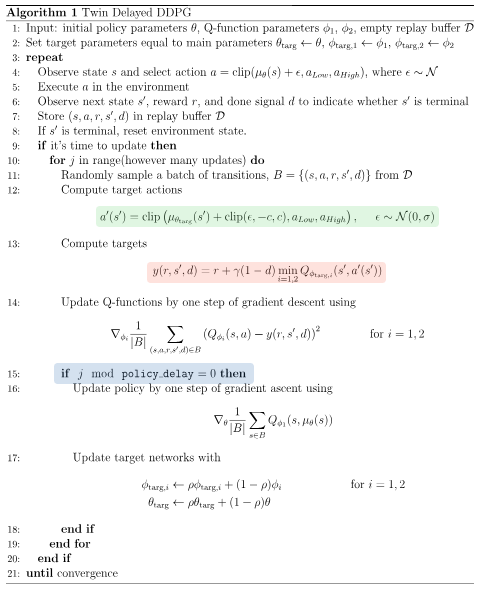

### 1.1.1. Delayed policy update
- TD3 updates the policy (and target networks) less frequently than the Q-function
- paper recommends one policy update for every two Q-function updates

### 1.1.2. Target policy smoothing
- Q-funktion sometimes has sharp spikes for several actions -> bad behaviour for policy
- TD3 adds noise to the target action
- DDPG adds noise only in output action
- Q-Funktion smoothed by similar actions caused by added noise to target action $a'(s')$
- harder for the policy to exploit Q-function errors by smoothing out Q along changes in action

$$ a'(s') = clip(r + \mu_{\theta_{targ}}(s')+clip(\epsilon,-c,c),a_{Low},a_{High}), \epsilon{\sim}N(0,\sigma) $$

### 1.1.3. Clipped double Q-Learning

- TD3 learns two Q-functions instead of one (hence “twin”)
- takes smaller Q-value to form the targets in the Bellman error loss functions
- original wording: IF target networks can be used to reduce the error over multiple updates, and policy updates on high-error states cause divergent behavior, then the policy network should be updated at a lower frequencey than the value network, to first minimize error before introducing a policy update. We propose delaying policy updates until the value error is as small as possible. [...] The less frequent policy updates that do occur will use a value estimate with lower variance, and in principle, should result in higher quality policy updates. -> generates a "two-timescale" algorithmen.



#### Interesting Info
- noise used for exploration in training
- higher-quality training data by reducing the scale of the noise of target action over the course of training is an option

source: https://spinningup.openai.com/en/latest/algorithms/td3.html


--> ToDo: Rework individual chapters with content of presentation


- - - 

## **2. Our TD3 implementation**


### 2.1. RL extension
-> Our code: Changes in the code compared to DDPG => td3.py



**==> see project assigment**

 
### 2.2. Hyperparameters

TD3 has a several hyperparameters, which strongly affect the training of the algorithm and the model quality. 

**General parameters:​**
- Discount factor (γ) -> immediate rewards > future rewards​
- Update weight (τ)   -> how much target network is updated ​
- ε-greedy (ε)        -> random action with ε-probability for exploration​
- Learning-rate (lr)  -> learning rate for neural network optimizer​

**TD3 specific parameters:​**
- Target action noise (σ) -> smoothing q-function by adding noise to action​
- Update frequency        -> Update rate of actor and target networks​

**Further parameters:​**
- Noise reduction -> reduce noise over time steps​
- Max reduction   -> max noise reduction

<br>

- - -

## **3. Test environment - Ant-v3**

This chapter describes the test environment "Ant-v3" from MuJoCo.,

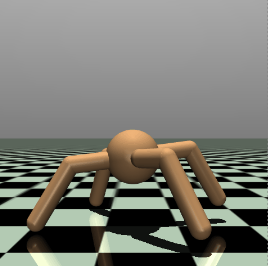


- Action Space​
  - 2 joints in each leg -> 8​
  - Continuous torque from -1 to 1 Nm​
- Observation Space​
  - 27 – 29 (extended) observations​
  - Positions, velocities, angular velocities and angles​

- Reward​
  - reward = healthy_reward + forward_reward - ctrl_cost - contact_cost​
- Episode end​
  - Any state space value is no longer finite​
  - z-coordinate of the torso is not in the defined interval


For further informations, please review: https://www.gymlibrary.dev/environments/mujoco/ant/

<br>

- - -

## 4. Usage of RL TD3 algorithm 


### 4.1. Training 

**==> add main_td.py**

### 4.2. Enjoy

**==> add enjoy.py**


<br>

- - -

## **5. Benchmark - Discussion**

### 5.1. DDPG GT vs. TD3 GT
#### 5.1.1. Learning phase


- Delayed policy updated lead to more stable actor training losses ​
- Double Q learning combats overestimation successfully (percentage to be evaluated of our data -> 0.92%)​
- Added target policy noise smoothens exploitation of a possible q-function error ​
- Change from Epochs & steps to Steps to ensure complete use of training budget​
- Delayed learning start stabilizes and optimizes the training​

​

==> Add new graphics from the presentation 


#### 5.1.2. Trained model

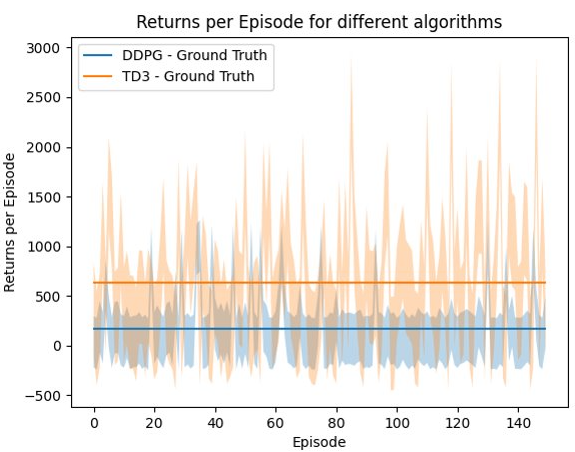

### 5.2. TD3 Trained model - Hyperparameter tests 

Compared to the ground truth, various isolated permutations of the hyperparameters have shown the following result: 

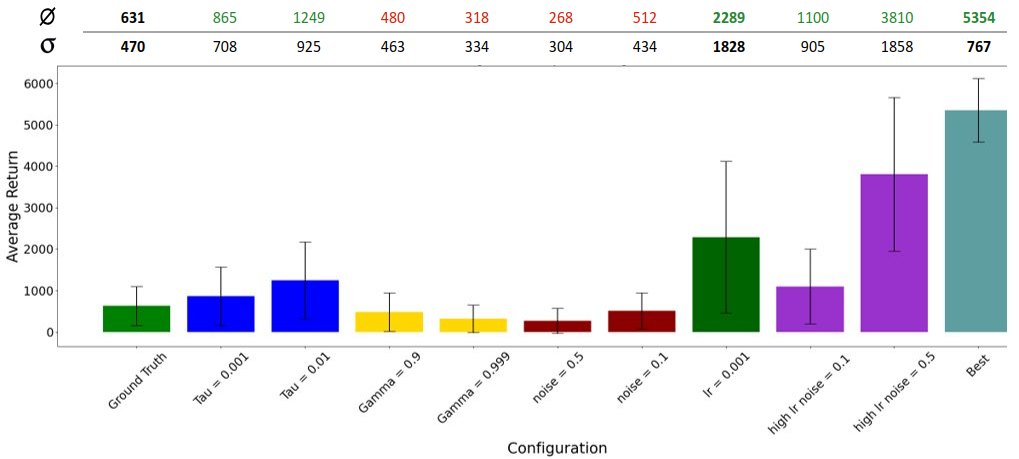

A review of the graphic shows that an isolated increase of tau and of the learning rate have the biggest influence. <br>

As the influence of the learning is higher than the one of tau, the following evaluation concentrates on models with a learning rate of 0.001. <br>

Additional permutations of the noise have show that a combination of a higher learning rate and a higher noise lead to a remarkable increase in the average reward of a trained model. 

Building on this, the policy noise was reduced over the training time in the next test runs. It has shown even better results as it gets visible in the graphic below.





### 5.3. Our TD3 Best vs. Stable Baselines

Besides the comparison to DDPG, our TD3 model with the best configuration can be benchmarked to the one of Stable Baseline.<br>
Stable Baselines is as a set of improved implementations of Reinforcement Learning algorithms which are based on OpenAI Baselines. (see: https://stable-baselines.readthedocs.io/en/master/#)

The benchmark is performed based on 150 episodes with a maximum of 1000 timesteps.

The result of this benchmark can be visualized as follows: <br>
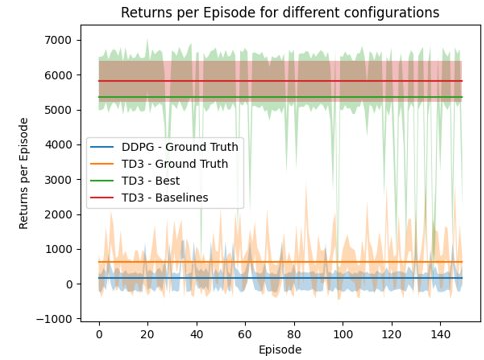



| Model                | Average return | Standard deviation |
|---                   |---             |---                 |
| DDPG Ground Truth    |     170        |      259           |
| TD3 Ground Truth     |     631        |      470           |
| TD3 Best model       |     5354       |      767           |
| TD3 Stable Baselines |     5813       |      589           |


**Findings**: 
- TD3 Ground Truth performs better than DDPG Ground Trouth
- The tweaking of hyperparameters has an remarkable influence to the results of the algorithm. 
- Significant improvements within the basic algorithm are possible 
- TD3 Best model reaches nearly the performance of the stable baselines one
- Reward shaping of healthy z-range would lead to increased returns ​and decreased standard deviations



- - -

## **5. Summary**

- TD3 achieved better results than DDPG through simple changes​
- Individual components contribute little to improvement(Fujimoto, et al. (2018))​
- A higher learning rate and policy noise with reduction over time greatly improved results, comparable to stable baselines​
- Noticeable reduction in training time compared to DDPG​

- More in depth studies for TD3 parameter permutations could yield even better results​
- More in depth studies for parameter permutations of DDPG could substantiate sensitivity reduction​
- Implementation requires optimization for replay buffer and parallel training



- - -

## **6. Conclusion**



- - -

## **7. Further material**

**GitHub Repos**
- TD3-RLE: 
- Stable Baselines: https://github.com/openai/baselines
- DLR - RL Baselines Zoo: https://github.com/DLR-RM/rl-baselines3-zoo

**Environment from MuJoCo**
- Ant-v3: https://www.gymlibrary.dev/environments/mujoco/ant/

**Useful information:**
- OpenAI Spinning Up: https://spinningup.openai.com/en/latest/


<br>
<br>

==> Add helpful links
  